# Processo de difusão

O processo de difusão consiste no espalhamento de um material em outro material. Por exemplo, o espalhamento de um gás em uma sala ou de um corante em um recipiente com água. Veremos como esse processo pode ser simulado.

### Distribuição Normal Padrão

A distribuição Normal, também chamada de Gaussiana, é muito importante para descrever diversos processos estatísticos. A distribuição é determinada por dois parâmetros: a média e a variância. A raiz quadrada da variância é chamada de desvio padrão.

A distribuição normal padrão consiste na distribuição normal possuindo média 0 e variância 1.

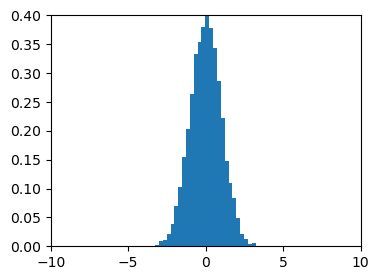

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch


def plot_hist(values):

    plt.hist(values, bins=30, density=True)
    plt.xlim((-10, 10))
    plt.ylim((0, 0.4))

# Sorteia 10000 valores de acordo com a distribuição normal padrão
values = torch.randn(10000) 
plot_hist(values)

Um valor gerado pela distribuição normal padrão pode ser transformado em um valor gerado por uma distribuição normal possuindo uma média e variância específicas. Para isso, basta multiplicar o valor pela raiz quadrada da variância e somar o resultado pela média desejada:

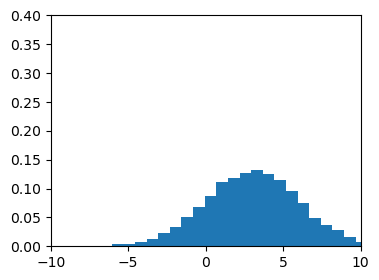

In [2]:
mean = 3    # Média da distribuição
var = 9     # Variância da distribuição. O desvio padrão é sqrt(var) ou var**0.5
values2 = var**0.5*values + mean

plot_hist(values2)

### Adição de ruído

Dado um valor inicial `x_0`, é possível adicionar ruído a `x_0` usando um valor sorteado de acordo com a distribuição normal:

In [11]:
# Execute esta célula várias vezes e veja o resultado
def add_noise(x_0, mean=0, var=1):

    noise = var**0.5*torch.randn(1) + mean
    x_1 = x_0 + noise

    return x_1

x_0 = -5
print(add_noise(x_0))

tensor([-4.8945])


Vamos repetir diversas vezes o experimento de adicionar ruído e salvar o resultado de cada realização. Os valores podem ser visualizados como um histograma:

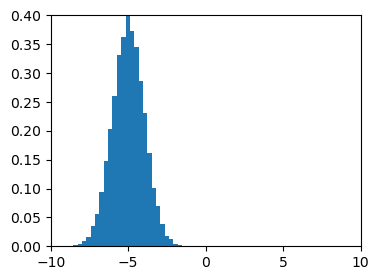

In [12]:
def add_noise_repeat(x_0, mean=0, var=1):

    n = 10000  # Número de repetições do experimento

    x_1s = []
    for _ in range(n):
        x_1 = add_noise(x_0, mean, var)
        x_1s.append(x_1.item())

    return x_1s
    
x_1s = add_noise_repeat(x_0)
plot_hist(x_1s)

In [13]:
# Média e variância dos valores após adição de ruído
print(torch.mean(torch.tensor(x_1s)))
print(torch.var(torch.tensor(x_1s)))

tensor(-4.9943)
tensor(1.0456)


### Difusão

A aplicação de um ruído a `x_0` diversas vezes em sequência gera um caminho aleatório começando em `x_0`. Esse processo é chamado da passeio aleatório, ou também de movimento Browniano. Cada aplicação do ruído é chamada de um `passo`.

A descrição macroscópica desse processo é chamada de difusão. A descrição macroscópica consiste em modelar a distribuição de probabilidade de encontrar a partícula em cada posição x após n passos.

(-30.0, 30.0)

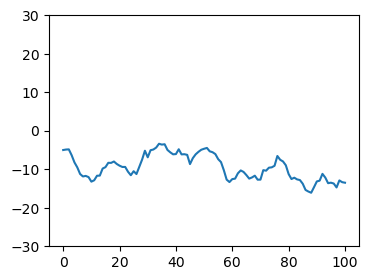

In [47]:
def diffuse(x_0, steps, mean=0, var=1):
    """Aplica um ruído normal `steps` vezes ao valor `x_0`."""

    x = x_0
    x_ts = [x]
    for _ in range(steps):
        x = add_noise(x, mean, var)
        x_ts.append(x.item())

    return x_ts

x_ts = diffuse(x_0, steps=100)
plt.plot(x_ts)
plt.ylim((-30, 30))

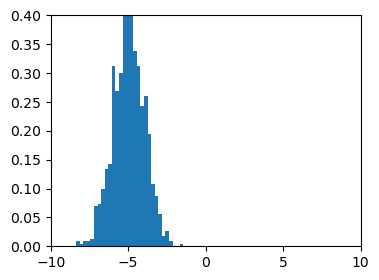

In [58]:
def diffuse_repeat(x_0, steps, mean=0, var=1):
    """Aplica um ruído normal `steps` vezes ao valor `x_0`, e salva a posição
    final obtida. O processo é repetido diversas vezes."""

    n = 1000  # Número de repetições do processo

    x_finals = []
    for _ in range(n):
        # [-1] indexa a última posição retornada por `diffuse`
        x_final = diffuse(x_0, steps, mean, var)[-1]
        x_finals.append(x_final)

    return x_finals

x_finals = diffuse_repeat(x_0, steps=1)
plot_hist(x_finals)

Vamos realizar `steps` passos do processo diversas vezes, e salvar os valores finais. A simulação é repetida para diferentes valores de `steps`:

In [49]:
from IPython import display


def diffusion_evolution(x_0, max_steps, mean):
    """Armazena as posições finais obtidas após `steps` adições de ruído, sendo
    que `steps` é variado de 0 a `max_steps`."""

    probs_per_step = []
    for steps in range(max_steps):
        x_finals = diffuse_repeat(x_0, steps, mean=mean)
        probs_per_step.append(x_finals)

    return probs_per_step

probs_per_step = diffusion_evolution(x_0, max_steps=20, mean=0.4)

A visualização dos resultados mostra que a distribuição das probabilidades **difunde** ao longo do espaço. Ela começa na posição `x=-5` com um pico pronunciado. Aos poucos, o pico da distribuição diminui e é deslocado para a direita. A distribuição fica mais larga pois a incerteza sobre a posição é maior:

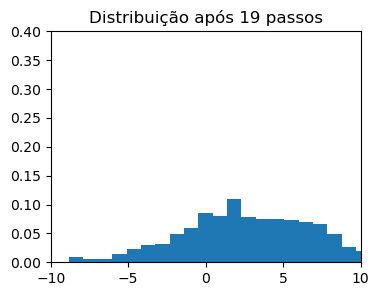

In [59]:
import time

for step, x_finals in enumerate(probs_per_step):
    plot_hist(x_finals)
    plt.title(f"Distribuição após {step} passos")
    display.clear_output(wait=True)
    plt.show() 
    time.sleep(1)

Essa distribuição é similar à que seria obtida se estivéssemos tentando descrever a difusão de um gás ou líquido em outro material!

### Adição de ruído em imagens

Veremos abaixo o processo específico utilizado para adicionar ruídos em imagens para tarefas de geração de imagens artificiais. O processo é baseado nas equações do artigo [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239). O próximo notebook (Modelo incondicional) mostrará a implementação do processo completo, incluindo a remoção do ruído.

In [10]:
from PIL import Image

x_0 = Image.open("../data/basset_hound_53.jpg")
x_0 = torch.from_numpy(np.array(x_0))/255
# Converte os valores do invervalo [0,1] para [-1,1] 
x_0 = x_0*2 - 1

In [11]:
# Variância do ruído inicial do processo de difusão
beta_start = 0.0001 
# Variância do ruído no passo final do processo de difusão
beta_end = 0.02
# Número de passos total do processo
n_steps = 1000
# Ruído adicionado a cada passo
betas = torch.linspace(beta_start, beta_end, n_steps)
# Produto acumulado de 1-variância (representa o quanto da imagem foi 
# preservado após n passos)
alphas = (1-betas).cumprod(dim=0)   

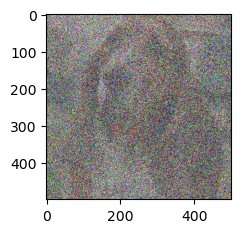

In [12]:
step = 500    # Passos da difusão

alpha_t = alphas[step]
noise = torch.randn(x_0.shape)

# Equação do artigo DDPM utilizada para criar a imagem ruidosa. Ela representa
# uma soma ponderada entre a imagem original e um ruído. 
z_t = alpha_t.sqrt()*x_0 + (1-alpha_t).sqrt()*noise
z_t = (z_t+1)/2
z_t = z_t.clamp(0, 1)

plt.imshow(z_t)